In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
training_data = pd.read_json("{\"M\":{\"2\":9.0,\"3\":9.0,\"4\":9.0,\"1\":10.0},\"%NecONG\":{\"2\":0.2016129032,\"3\":0.2016129032,\"4\":0.2016129032,\"1\":0.2016129032},\"%NecRO\":{\"2\":0.2016129032,\"3\":0.2016129032,\"4\":0.2016129032,\"1\":0.2016129032},\"%NecRA\":{\"2\":0.1,\"3\":0.1,\"4\":0.1,\"1\":0.625},\"%VolONG\":{\"2\":0.11,\"3\":0.11,\"4\":0.11,\"1\":0.11},\"%VolRO\":{\"2\":0.11,\"3\":0.11,\"4\":0.11,\"1\":0.11},\"%VolRA\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.11},\"SuONG\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"SuRO\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"VisONG\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"VisRO\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"VisRA\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"Dis\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"Dias\":{\"2\":0.0,\"3\":-1.0,\"4\":0.0,\"1\":6.0},\"Camp\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"C1\":{\"2\":1.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"C2\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":1.0},\"F1\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":1.0},\"F2\":{\"2\":0.0,\"3\":0.0,\"4\":0.0,\"1\":0.0},\"%Comp\":{\"2\":0.1,\"3\":0.0,\"4\":0.0,\"1\":0.2096774194}}")
features = ['M', '%NecONG', '%NecRO', '%NecRA', '%VolONG', '%VolRO', '%VolRA', 
        'SuONG', 'SuRO', 'VisONG', 'VisRO', 'VisRA', 'Dis', 'Dias', 'Camp']
training_data


,M,%NecONG,%NecRO,%NecRA,%VolONG,%VolRO,%VolRA,SuONG,SuRO,VisONG,VisRO,VisRA,Dis,Dias,Camp,C1,C2,F1,F2,%Comp
1,10,0.201613,0.201613,0.625,0.11,0.11,0.11,0,0,0,0,0,0,6,0,0,1,1,0,0.209677
2,9,0.201613,0.201613,0.100,0.11,0.11,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0.100000
3,9,0.201613,0.201613,0.100,0.11,0.11,0.00,0,0,0,0,0,0,-1,0,0,0,0,0,0.000000
4,9,0.201613,0.201613,0.100,0.11,0.11,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0.000000


In [6]:
M, features = training_data.sample(frac=1), features[:-1] # Random
Mtrain, Mtest = train_test_split(M, test_size=0.2)
print("Training shape: " + str(Mtrain.shape) + ". Test shape: " + str(Mtest.shape))

Training shape: (3, 20). Test shape: (1, 20)


In [7]:
y = pd.DataFrame()
y["pred"] = M["%Comp"]
training_data = M.drop(["%Comp"], axis=1)
training_data = preprocessing.scale(training_data)

parameters = {
    'kernel': ('linear', 'rbf','poly'), 
    'C': np.linspace(0.1, 1, num=5),
    'gamma': np.linspace(1e-11,1e-9, num=5),
    'epsilon': np.linspace(1e-11, 1e-9, num=5)
}
svr = GridSearchCV(SVR(), cv=2, param_grid=parameters)
svr.fit(training_data, y)

#print(svr.best_estimator_)
print(svr.predict(training_data))
#save_model_fecha_regressor(svr, features)

[-5.84840945e-04  1.94948326e-04  1.00194949e-01  2.09872353e-01]


AttributeError: 'GridSearchCV' object has no attribute 'model_'

In [8]:
%matplotlib inline

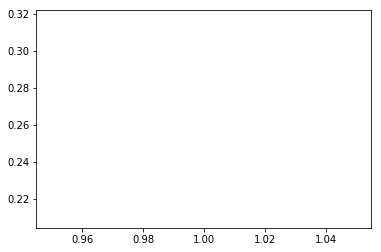

In [9]:
plt.plot(Mtest.index.values, Mtest['%Comp'], 'r', 
         Mtest.index.values, svr.predict(Mtest.loc[:, Mtest.columns != '%Comp']), 'b')